AR anomaly composites of different variables using different cEOF tests (e.g. DJF, MAM, DJF-MAM). 

Creates a 9 panel plot with the following variables in the columns
1. (upper) 250-hPa geopotential heights (contour lines), isotachs (contour shading), and wind vectors
2. (ivt) 
3. (precip)


## Imports

In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap, add_hasia_labels
from timeseries import persistence, create_list_all_dates
from statistical_tests import ttest_1samp_new
import nclcmaps as nclc

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [4]:
# choose season
ssn = 'djfmam'
ceofid = 'IVT'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters
lag = -4 # choose lead/lag (e.g. -4 is 4 day lag)

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

In [5]:
# import configuration file for dictionary choice
yaml_doc = '../data/plt_config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict_upper = config['upper_anom']
plot_dict_ivt = config['ivt_anom']
plot_dict_prec = config['precip_anom']

plot_dicts = [plot_dict_upper, plot_dict_ivt, plot_dict_prec]

# djf_dict mam_dict djfmam_dict
ar_dict = config[ssn]

### ERA5 renalysis

In [6]:
def preprocess(ds):
    '''
    keep only selected lats and lons and rename vars
    '''
    if pathvar == 'huvq':
        rename_dict = {'z': 'H', 
                       'u': 'U', 
                       'v':'V', 
                       'q': 'QV',
                       'latitude': 'lat',
                       'longitude': 'lon'}
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=lev)
        subset = subset.rename(rename_dict)

    if pathvar == 'ivt':
        rename_dict = {'p71.162': 'ivte', 
                       'p72.162': 'ivtn', 
                       'latitude': 'lat',
                       'longitude': 'lon'}
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
        subset = subset.rename(rename_dict)

    if pathvar == 'prec':
        rename_dict = {'mtpr': 'prec', 
                       'latitude': 'lat',
                       'longitude': 'lon'}

        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
        subset = subset.rename(rename_dict)
    
    return subset

In [7]:
# Select lat/lon grid 
bbox = [20, 110, 0, 55]
lonmin, lonmax, latmin, latmax = bbox
# select vars and levs
varlst = ['huvq', 'ivt', 'prec']
levlst = [250., None, None]

f = []

for i, (pathvar, lev) in enumerate(zip(varlst, levlst)):
    filepath_pattern = path_to_data + 'ERA5/{0}/anomalies/daily_filtered_anomalies_{0}_*.nc'.format(pathvar)
    f.append(xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords'))

# merge huvq and ivt
ds1 = xr.merge(f[:2], compat='override')
# keep prec separate
ds2 = f[2]
# add IVT magnitude
ds1 = ds1.assign(ivt=lambda ds1: np.sqrt(ds1.ivte**2 + ds1.ivtn**2))
# convert geopotential to geopotential height (m)
ds1 = ds1.assign(H=lambda ds1: ds1['H']/(9.80665))
# convert prec units to mm/day
ds2 = ds2.assign(prec=lambda ds2: ds2['prec']*86400)
ds_lst = [ds1, ds2]

### AR days

In [8]:
filepath = out_path + 'AR-types_ALLDAYS.csv'
df1 = pd.read_csv(filepath)
df1 = df1.rename(columns={'Unnamed: 0': 'time'})
df1 = df1.set_index(pd.to_datetime(df1['time']))
df1.index = df1.index.strftime("%Y-%m-%d")
df1 = df1.drop(columns=['time'])
df1 = df1.reset_index()

tmp = pd.read_csv(path_to_out + 'DJFMAM_ARS_TRACKID_daily.csv')
tmp

df = pd.merge(df1, tmp, how='outer', on='time')
df = df.set_index(df.time)
df = df.drop(columns=['time'])
df

,AR_CAT,kidmap
time,,
1979-12-01,2,2861.0
1979-12-02,1,2861.0
1979-12-03,0,NaN
1979-12-04,0,NaN
1979-12-05,0,NaN
...,...,...
2019-05-27,0,NaN
2019-05-28,0,NaN
2019-05-29,1,128807.0


In [9]:
for i, ds in enumerate(ds_lst):
    # Trim date range
    idx = slice(ar_dict['start_date'], ar_dict['end_date'])
    ds = ds.sel(time=idx)
    
    # Select months
    if ar_dict['mon_s'] > ar_dict['mon_e']:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
    else:
        idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])
    ds = ds.sel(time=idx)
    
    # Combine AR Cat data w/ reanalysis data
    # Add ar time series to the ERA dataset
    ds['ar'] = ('time', df.AR_CAT)
    ds = ds.set_coords('ar')
    
    ds['trackID'] = ('time', df.kidmap)
    ds = ds.set_coords('trackID')
    
    ds_lst[i] = ds

### Compute AR Composites

In [10]:
def select_ar_days(era, lag=0):
    # Select only AR days
    idx = (era.ar >= 1)
    # select days with lag shift
    era_ar = era.shift(time=lag).sel(time=idx)
    
    return era_ar.compute()

In [ ]:
# # create single composite of 0 and -2 lag 
# for i, ds in enumerate(ds_lst):
#     ds0 = select_ar_days(era=ds, lag=0)
#     ds2 = select_ar_days(era=ds, lag=-2)
    
#     ds0 = ds0.groupby('ar').mean('time').compute()
#     ds2 = ds2.groupby('ar').mean('time').compute()

In [14]:
# ## export precip anomalies to nc
# if lag == 0:
#     fname = path_to_out+'precip_anom_{0}_{1}_eof{2}_k{3}.nc'.format(ssn, ceofid, str(neofs), str(nk))
#     era_ar_comp[1].to_netcdf(path=fname, mode = 'w', format='NETCDF4')
#     fname = path_to_out+'huv_ivt_anom_{0}_{1}_eof{2}_k{3}.nc'.format(ssn, ceofid, str(neofs), str(nk))
#     era_ar_comp[0].to_netcdf(path=fname, mode = 'w', format='NETCDF4')

In [11]:
data_lst = []
tval_lst = []


for i, ds in enumerate(ds_lst):
    # Lag=0, -2, +2
    ds = select_ar_days(era=ds, lag=lag)
    
    # repeat for each AR Type Grouping
    for k in np.arange(1, nk+1, 1):
        print('AR Type ', k)
        idx = (ds['ar'] == k)
        tmp_ar = ds.sel(time=idx)
        popmean = np.zeros([len(ds.lat), len(ds.lon)])
#         print(tmp_ar)

        # get number of unique events from trackID
        trackIDs = tmp_ar['trackID'].values
        nevents = len(np.unique(trackIDs))
        print(nevents)
        # calculate t-value based on nevents
        a_mean, tval_mask = ttest_1samp_new(a=tmp_ar, popmean=popmean, dim='time', n=nevents)
        data_lst.append(a_mean)
        tval_lst.append(tval_mask)

AR Type  1
605
AR Type  2
581
AR Type  3
1051
AR Type  1
605
AR Type  2
581
AR Type  3
1051


### Figures

### Common Plot Properties

In [12]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+10,10)
dy = np.arange(latmin,latmax+10,10)

# subregion info 
# [ymin, xmin]
sr_xy = [[65, 30], [75, 25], [85, 20]]
# width of subregion
sr_width = [10, 10, 10]
# height of subregion
sr_height = [10, 10, 10]

# 9-panel plot    
panel_9 = {'nrows': 3,
            'ncols': 2,
            'panel': '9pan'}

# # test plot    
# panel_test = {'nrows': nk,
#             'ncols': 3,
#             'artype_lst': list(range(1, nk+1)),
#             'panel': 'test'+str(neofs)+str(nk)}


panel_dict = panel_9

### Composite Plots

/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


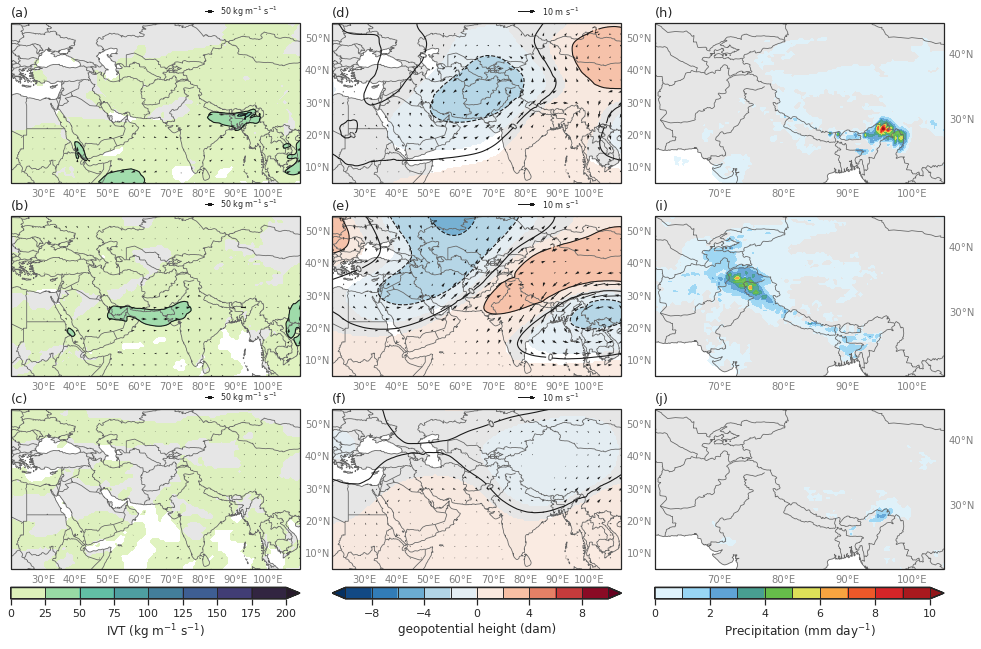

In [13]:
fig_dict = panel_dict
filepath = fig_path + 'lag' + str(lag) + '_composite_anomalies_' + fig_dict['panel'] + '.png'
nrows = nk
ncols = fig_dict['ncols']
row_lbl = ['AR Type 1', 'AR Type 2', 'AR Type 3']
col_lbl1 = ['(a)', '(b)', '(c)']
col_lbl2 = ['(d)', '(e)', '(f)']
col_lbl3 = ['(h)', '(i)', '(j)']

ext1 = [20, 110, 5, 55]
ext2 = [60, 105, 20, 45]

# Create figure
fig = plt.figure(figsize=(15,10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, [0.1, 0.1, 0.66, 0.8], axes_class=axes_class,
                nrows_ncols=(nrows, 2), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.25, cbar_size='7%',label_mode='',
                direction='column',
                aspect=True,
                share_all = False)

axgr2 = AxesGrid(fig, [0.7125, 0.1, 0.33, 0.8], axes_class=axes_class,
                nrows_ncols=(nrows, 1), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.25, cbar_size='7%',label_mode='',
                direction='column',
                aspect=True,
                share_all = False)
artype_lst = range(nk)

################################
########## IVT PLOTS ###########
################################
for k, (ax, ar_type) in enumerate(zip(axgr[0:nrows], artype_lst)):
    data = data_lst[ar_type]
    tval = tval_lst[ar_type]
    plot_dict = plot_dict_ivt
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
    # Contour Filled
    # IVT (filled contour) (only plot where significant)
    uvec = data.ivte.values
    vvec = data.ivtn.values
    ivt = np.sqrt(uvec**2+vvec**2)
#     ivt = data.ivt.values
    
    uvec_mask = data.ivte.where((tval.ivte == True) | (tval.ivtn == True)).values
    vvec_mask = data.ivtn.where((tval.ivte == True) | (tval.ivtn == True)).values
    ivt_mask = np.sqrt(uvec_mask**2+vvec_mask**2)
#     ivt_mask = data.ivt.where((tval.ivt == True))

    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])                       
    cf = ax.contourf(lons, lats, ivt_mask, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='max') 
    
    # Contour Lines (IVT all)
    cs = ax.contour(lons, lats, ivt, transform=datacrs,
                    levels=cflevs, colors='k', linewidths=1.1) 
    
    # Wind barbs / vectors (only plot where significant)
    Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
                  color='k', regrid_shape=15, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})
    
    # subtitles
    ax.set_title(col_lbl1[k], loc='left',fontsize=13)
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label(plot_dict['cb_label'])
    
#################################
########## UPPER PLOTS ##########
#################################

for k, (ax, ar_type) in enumerate(zip(axgr[nrows:nrows+nrows], artype_lst)):
    data = data_lst[ar_type]
    tval = tval_lst[ar_type]
    plot_dict = plot_dict_upper
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
    # Contour Filled
    # 250-hPa heights where significant
    hgts_mask = data.H.where(tval.H == True).values/10 #convert to dekameters
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cf = ax.contourf(lons, lats, hgts_mask, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='both')
    
    # Contour Lines
    # 250-hPa Heights (ALL)
    hgts = data.H.values/10 #convert to dekameters
    clevs = np.arange(plot_dict['clevs'][0], plot_dict['clevs'][1], plot_dict['clevs'][2])
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)  
        
    # Wind barbs / vectors (only plot where significant)
    # accept u and v if either is significant
    uwnd_mask = data.U.where((tval.U == True) | (tval.V == True)).values
    vwnd_mask = data.V.where((tval.U == True) | (tval.V == True)).values
    Q = ax.quiver(lons, lats, uwnd_mask, vwnd_mask, transform=datacrs, 
                  color='k', regrid_shape=15, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                     coordinates='axes', fontproperties={'size': 8.0})
    
    # subtitles
#     plt_label = 'AR Type {0}'.format(ar_type)
    ax.set_title(col_lbl2[k], loc='left',fontsize=13)
#     # Row labels
#     ax.text(-0.07, 0.55, row_lbl[k], va='bottom', ha='center',
#         rotation='vertical', rotation_mode='anchor', fontsize=13,
#         transform=ax.transAxes)
    
# Colorbar (single edge)
    cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='horizontal', drawedges=True)
    cb.set_label(plot_dict['cb_label'])



################################
########## PREC PLOTS ##########
################################
artype_lst = range(nk, len(data_lst))
for k, (ax, ar_type) in enumerate(zip(axgr2, artype_lst)):
    data = data_lst[ar_type]
    tval = tval_lst[ar_type]
    plot_dict = plot_dict_prec
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
    # Contour Filled

    # Precip (filled contour) (only plot where significant)
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
#     cmap=plot_dict['cmap']
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    prec_mask = data.prec.where(tval.prec == True).values
    cf = ax.contourf(lons, lats, prec_mask, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

    
    # subtitles
    ax.set_title(col_lbl3[k], loc='left',fontsize=13)
    # add hasia labels
#     add_hasia_labels(ax=ax, fntsize=5)
    
# # Colorbar (single)
    cb = fig.colorbar(cf, axgr2.cbar_axes[0], orientation='horizontal', drawedges=True)
    cb.set_label(plot_dict['cb_label'])
    
# Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
